# Lineage tracing data analysis
\ZP{maybe the title should be just Lineage Tracing?}

## Background

Cellular lineages are ubiquitious in biology. Perhaps the most famous example is that of embyrogenesis: the process by which an organism like a human being is generated from from a single cell, the fertilized egg. During this process, subsequent cell divisions give rise to daughter cells and over time entire "lineages" that can take on specialized roles within the developing embryo. The amazing complexity of this process has captured the imagination of scientists for centuries, and over the past century and a half our understanding of this process has been bolstered by the development of high-throughput sequencing assays and new "lineage tracing" technologies for visualizing and characterizing this process {cite}`woodworth2017`. Amongst the most exciting of these methods allow investigators to link measurements of cell state with models of their history, thus providing a window into how differentiation trajectories might have unfolded.

The marriage of single-cell assays and lineage tracing approaches has yielded an exponential growth in the complexity of datasets, requiring the development of new computational methodology for their analysis. As such, there has been a strong need in developing new computational methodology for processing these datasets {cite}`gong2021`. Sourcing heavily from population genetics literature, the past half decade has witnessed an exciting confluence of traditional concepts in evolutionary biology with cutting-edge genome engineering techniques.     

In this chapter, we provide a brief overview of these new technologies and focus on the available computational pipelines for the analysis of their output and extraction of biological insight. To note, the pay special focus with our example to the CRISPR/Cas9-based "evolving" lineage tracing setting. However, there exist several other greatly useful experimental alternatives; for a more complete view, we refer the interested reader to the excellent reviews by Wagner & Klein {cite}`wagner2020`, Mckenna & Gagnon {cite}`mckenna2019`, and VanHorn & Morris {cite}`vanhorn2021`.

## Lineage tracing technologies

The goal of lineage tracing techniques is to infer lineage, or ancestry relationships between observed cells. In this, there are two major variables to consider: scale and resolution. Classical approaches relied heavily on visual observation: for example, in the 1970s Sulston and colleagues derived the first developmental lineage of the nematode _C. elegans_ by meticulously watching cell divisions under a microscope {cite}`sulston1983`. While playing an imperative role in the progression of the field, such approaches cannot scale to complex organisms with more stochastic developmental lineages.

Over the past two decades, the development of revolutionary sequencing assays and microfluidic devices has contributed to the development of new and diverse lineage tracing methodology {cite}`wagner2020`. To digest the plethora of techniques, it is helpful to classify approaches as "_prospective_" or "_retrospective_". Generally speaking, prospective lineage tracing approaches use a heritable marker to trace a clonal population (i.e., all the descendants of a single cell). On the other hand, retrospective lineage tracing approaches use variability amongst observed cells - such as naturally occuring genetic mutations - to infer a model of their lineage, or "_phylogeny_", summarizing the cell division history of a clonal population.

Several approaches have been developed for prospectively tracing a clonal population: for example, recombinases under a tissue-specific promoter can be used to activate fluorscent markers that act as heritable marks for a specific tissue lineage {cite}`weissman2015brainbow`, {cite}`nagy2000`, {cite}`liu2020genetic`, {cite}`liu2020triple`, {cite}`he2017`. Alternatively, lentiviral transduction can be used to integrate random DNA barcodes into cellular genomes to provide a heritable mark that can be used to deconvovle clonal identities with a sequencing readout {cite}`gerrits2010`, {cite}`biddy2018`, {cite}`weinreb2020`, {cite}`yao2017`. Though these approaches are highly scalable and often do not require heavy genome engineering, they can only report properties at the clonal-level such as clone size and composition.

Retrospective lineage tracers overcome these limitations and provide an additional advantage over prospective tracers by reporting properties about the *sub*clonal dynamics of clones. Traditionally, this has been done by leveraging natural variation between cells to reconstruct a cell division history, such as single-nucleotide variation {cite}`vogelstein2013`, {cite}`turajlic2016`, {cite}`bailey2021`, {cite}`gerstung2020`, {cite}`abyzov2020` or copy-number-variation {cite}`Patel2014`, {cite}`Gao2021`. While this approach is still widely and successfully used to study human tumors or tissue developmental histories, experimentalists have little or no control over how often or where mutations occur. In experimental models, there are opportunities to recapitulate the advantages of retrospective tracers while improving on the caveats by engineering evolvable lineage tracers. Such evolving tracers typically consist of engineering cells with a "scratchpad" (or, synonymously, "target site") that can acquire mutations {cite}`wagner2020`, {cite}`mckenna2019`. For example, a popular approach that this chapter focuses on uses Cas9 to introduce insertions and deletions (i.e., "indels") at the target site {cite}`mckenna2016whole`, {cite}`spanjaard2018`, {cite}`chan2019`, {cite}`frieda2017`, {cite}`kalhor2018`, {cite}`alemany2018`. In this way, cellular lineages acquire heritable mutations over time that can be subsequently read out with high-throughput sequencing platforms and used to infer phylogenies representing a model of the cell lineage.

To note, both classes of lineage-tracing approaches can take advantage of adjacent advances in single-cell multiomic profiling. For example, investigators have routinely used single-cell RNA-seq (scRNA-seq) to read out simultaneously the functional state of single cells and their lineage relationships {cite}`raj2018large`, {cite}`chan2019`, {cite}`weinreb2020`, {cite}`wagner2019`, {cite}`spanjaard2018`. This multimodal readout has created opportunity for new computational methodologies, which we detail below. 

As stated above, in this chapter we provide a **detailed walkthrough on the analysis of data from evolving CRISPR/Cas9-based lineage tracers.**

\ZP{verify the citations, especially `liu2020genetic`,`liu2020triple`, `turajlic2016`, `bailey2021` (added also an alternative `bailey2020`)}

## Overview of evolving lineage tracing data analysis pipelines

Before delving into the analysis of our example dataset, we will provide an overview of the computational pipeline for the analysis of data generated by evolving tracers (based on {cite}`jones2020`). In general, with these systems, analysis will begin with raw sequencing data of an _amplicon_ library of target sites (often derived from a conventional scRNA-seq platform like 10X Chromium). Depending on the technology at hand, each sequenced amplicon will be between 150-300bp long; in the case of CRISPR/Cas9-based evolving tracers, each read will contain one more Cas9 cut sites. Within the preprocessing of this data, anlaysts are tasked with aligning the reads to a reference sequence and identifying any mutations (e.g., indels). 

While the preprocessing of these datasets is a critical step, in the interest of space, we focus on analysis pipelines  that receive preprocessed sequencing data as input and refer the reader to an external preprocessing tutorial which can be found [here](https://cassiopeia-lineage.readthedocs.io/en/latest/notebooks/preprocess.html). 

In most analysis frameworks, the preprocessing of the raw sequencing reads produces a data structure called the **character matrix** that summarizes the observed mutations in each cell across the target sites. In this data structure, each row is a cell (or "sample"), each column is a target site (or "character"), and the (row, column) values are categorical variables representing the identity of the indel observed in that cell at that particular cut site (or "character-state"). Depending on the technology at hand, these character matrices can report on anywhere between 100 and 10,000 samples across up to 100 characters.

At this point, this data structure abstracts away the technicalities of the evolving lineage tracing assay and opens up the opportunity to computationally infer a **phylogenetic tree** over the cells. Specifically, the goal is to learn a hierarchical tree structure over each of the cells in our character matrix. In this tree, each node represents a sample and each edge represents a lineage relationship. Importantly, we often have only observed the _leaves_ of the tree and we refer to any of the unobserved set of internal nodes as _ancestral_ nodes. (To note, we tend to use the term "phylogenetic tree" loosely as this has a precise definition. In reality, we often infer a cladogram summarzing the relationships between cells.)

There are many algorithmic choices for inferring the phylogenetic tree from the character matrix, which can be generally broken up into "character-based" and "distance-based" approaches:
- **Character-based** (e.g. Maximum-Parsimony): perform a combinatorial search through all possible tree topologies while seeking to optimize a function over the characters (e.g., the likelihood of the evolutionary history given the mutations observed in the characters). 
- **Distance-based** (e.g Neighbor-Joining): use a notion of cell-cell distances (denoted by $\delta$) to infer a phylogenetic tree and typically run in polynomial time. While distance-based approaches can perform much faster, they require one to iteratively find the best cell-cell dissimilarity function which can be equally time consuming.

Following phylogenetic tree reconstruction, there are several options for _downstream analysis_. For example, one can learn about the rates of cell state changes across the developmental history or the relative propensities of cells to divide in a population. Below, we will demonstrate via code examples how these different components fit together to gain fundamental insights into the dynamic processes underlying cellular lineages.

## `Cassiopeia` for lineage tracing analysis

In this tutorial, we will primarily make use of `Cassiopeia` a package for lineage tracing analysis which was introduced in “Inference of Single-Cell Phylogenies from Lineage Tracing Data” {cite}`jones2020`.

`Cassiopeia` is a software suite for processing and analysing CRISPR/Cas9-based lineage tracing sequencing data. The software contains three modules for:
1. preprocessing sequencing reads into character matrices. 
2. reconstructing phylogenies from these character matrices.
3. providing analysis tools for deriving insights from these phylogenies. 
For more details and installation guidelines see [here](https://cassiopeia-lineage.readthedocs.io/en/latest/index.html)

## Environment setup.

Before we enter this notebook's analysis, let's set up our environmnet.

In [ ]:
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from cassiopeia.preprocess import lineage_utils

<div class="alert alert-block alert-warning" style="color:black;">
<b>Heads up!</b> 
<br/br>
    You should be sure to have python3.7 or above installed to follow this tutorial. Also, if you haven't yet, you can install Cassiopeia by following the instructions on <a href="https://github.com/Yoseflab/Cassiopeia">the Cassiopeia github page</a>.
</div>


# Case Study: Tracing tumor development in a mouse model of lung cancer
In this case study, we will make use of the recent study presented in {cite}`yang2022`. Briefly, in this study the authors integrated a evolving CRISPR/Cas9-based lineage tracer into the KP mouse model of non-small-cell lung cancer {cite}`dupage2009`. Specifically, this mouse model carries oncogenic _Kras_ and _Tp53_ mutations that under native conditions are not expressed. However, upon the introduction of Cre recombinase via lentiviral inhalation, these oncogenic mutations are activated in single cells of the lung airway epithelium inducing tumors. In this study, the CRISPR/Cas9-based lineage tracer is under similar control and thus becomes active simultaneously upon tumor induction.


<div>
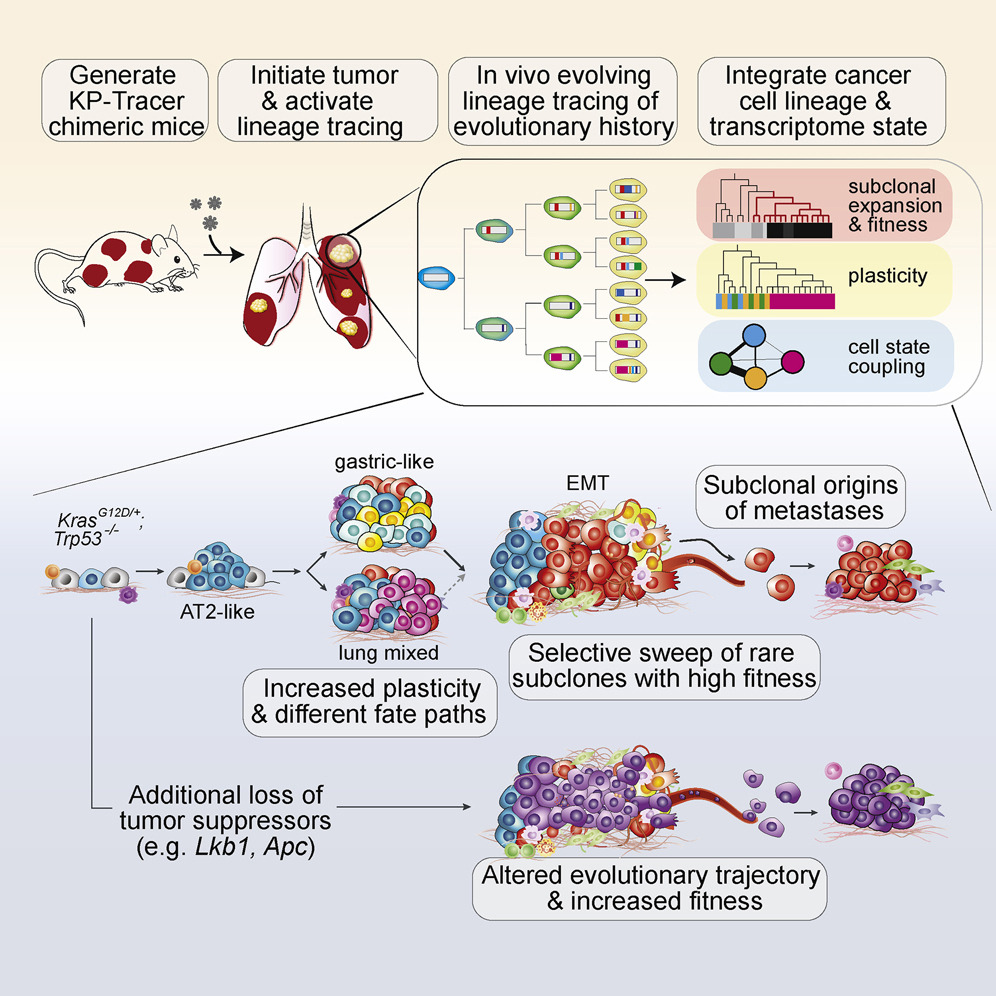
</div>

With this system, the authors followed tumors from their single-cell origins over the course of approximately 4.5-6 months at which point they harvested aggressive, metastatic tumors. After dissociation of the tumors, the authors profiled both the lineage tracing target sites and the RNA content of single cells. This resulted in a large dataset of more than 70,000 cells across more than 100 tumors with both lineage and scRNA-seq information.

In this tutorial, we will demonstrate how a user can take processed target site data to learn interesting dynamic properties of lineages. Throughout this case study, each lineage will correspond to a single primary tumor sampled from a mouse lung.

<div class="alert alert-block alert-warning" style="color:black;">
<b>Structure of the Data:</b> 
<br/br>
    For the dataset analyzed below, each cell is engineered with approximately 10 target sites, each of which carrying 3 Cas9 cut sites in tandem. Each target site is labeled with a unique integration barcode ("intBC" for short). All together, we can expect to observe 3*(# target sites) characters in each cell that can accumulate mutations and be used for lineage inference. For more information on the structure of the sequencing cassette, please refer to <a href="https://www.nature.com/articles/s41586-019-1184-5">Chan, Smith et al. Molecular recording of mammalian embryogenesis. Nature 2019</a>.
</div>


## Downloading the data
This data is publicly hosted on [Zenodo](https://zenodo.org/record/5847462#.YrFDKuzMI6A) and we can download the data as follows:

In [ ]:
!wget https://zenodo.org/record/5847462/files/KPTracer-Data.tar.gz?download=1

In [ ]:
!tar -xvzf KPTracer-Data.tar.gz?download=1

## Examine the data

After preprocessing of the target site sequencing data, `Cassiopeia` uses an `allele_table` to summarize the mutations observed on each target site integration.

As described above, the system at hand should have approximately ~10 target sites per cell where each target site contains three Cas9 cut sites. Columns labeled `intBC` indicate the target site and columns labeled `r*` indicate the Cas9 cut sites on that target site. Mutations in each cut site are stored as CIGAR strings, indicating the size and type of indel observed. 

Other meta data can also be stored in this table such as the total number of UMIs and reads associated with the target site molecule, which cell the molecule came from, and which tumor that cell belongs to.

In [ ]:
allele_table = pd.read_csv("KPTracer-Data/KPTracer.alleleTable.FINAL.txt", sep='\t', index_col = 0)

allele_table.head(5)

We'll focus on the data from KP tumors without any additional perturbations:

In [ ]:
all_tumors = allele_table['Tumor'].unique()
primary_nt_tumors = [tumor for tumor in all_tumors if 'NT' in tumor and tumor.split("_")[2].startswith("T")]

primary_nt_allele_table = allele_table[allele_table['Tumor'].isin(primary_nt_tumors)]

As described above, we expect to see around 10 unique intBCs (i.e., target sites) per tumor population. Below, we summarize some key statistics for the dataset.

### Number of intBCs per Tumor

In [ ]:
primary_nt_allele_table.groupby(['Tumor']).agg({"intBC": 'nunique'}).plot(kind='bar')
plt.ylabel("Number of unique intBCs")
plt.title("Number of intBCs per Tumor")
plt.show()

### Size of each tumor

In [ ]:
primary_nt_allele_table.groupby(['Tumor']).agg({"cellBC": 'nunique'}).sort_values(by = 'cellBC', ascending=False).plot(kind='bar')
plt.yscale('log')
plt.ylabel("Number of cells (log)")
plt.title("Size of each tumor")
plt.show()

## Preparing the data for lineage reconstruction

A general feature of Cas9-based tracers is that certain insertions and deletions are much more common than others. This can be an important modeling concern as high-probability edits can occur several times independently of one another and could potentially lead to an analyst incorrectly believing that two cells are related to one another. 

Cassiopeia has a built-in utility for estimating the prior probabilities of insertions and deletions by counting the number of times that an indel appeared in unrelated tumors or intBCs. 

In [ ]:
indel_priors = cas.pp.compute_empirical_indel_priors(allele_table, grouping_variables=['intBC', 'MetFamily'])

indel_priors.sort_values(by='count', ascending=False).head()

### Filtering out low-quality tumors
Before tumor reconstruction, we'll filter out tumors with (i) poor lineage tracing kinetics or (ii) that are too small to consider for analysis. 

In previous publications, we have found that looking at the following statistics are useful for determining the quality of the tumor:
- **percent unique**: This is the percentage of lineage states that are unique in a tumor.
- **percent cut**: This is the percentage of Cas9 targets that are mutated in a population of cells.
- **percent exhausted**: This is the fraction of target sites that are identical across cells (i.e., are exhausted)
- **size of tumor**: The number of cells in a tumor.

In [ ]:
# utility functions for computing summary statistics

def compute_percent_indels(character_matrix):
    """Computes the percentage of sites carrying indels in a character matrix.
    """
    all_vals = character_matrix.values.ravel()
    num_not_missing = len([n for n in all_vals if n != -1])
    num_uncut = len([n for n in all_vals if n == 0])

    return 1.0 - (num_uncut / num_not_missing)

def compute_percent_uncut(cell):
    """Computes the percentage of sites uncut in a cell.
    """
    uncut = 0
    for i in cell:
        if i == '0':
            uncut += 1
    return uncut / max(1, len([i for i in cell if i != -1]))

### Calculate and visualize tumors' statistics

In [ ]:
tumor_statistics = {}

# iterate through Tumors and compute summary statistics
for tumor_name, tumor_allele_table in primary_nt_allele_table.groupby('Tumor'):
    
    if tumor_allele_table['cellBC'].nunique() < 2:
        continue

    tumor_allele_table = primary_nt_allele_table[primary_nt_allele_table['Tumor'] == tumor_name].copy()
    tumor_allele_table['lineageGrp'] = tumor_allele_table['Tumor'].copy()
    lineage_group = lineage_utils.filter_intbcs_final_lineages(tumor_allele_table, min_intbc_thresh=0.2)[0]

    # drop normal cells from lineage 
    number_of_cutsites = len(lineage_group['intBC'].unique())*3
    
    try:
        character_matrix, _, _ = cas.pp.convert_alleletable_to_character_matrix(lineage_group, allele_rep_thresh = 0.98)
    except:
        character_matrix, _, _ = cas.pp.convert_alleletable_to_character_matrix(lineage_group, allele_rep_thresh = 1.0)
    
    number_dropped_intbcs = (number_of_cutsites - character_matrix.shape[1]) 
    percent_uncut = character_matrix.apply(lambda x: compute_percent_uncut(x.values), axis=1)

    character_matrix_filtered = character_matrix[percent_uncut < 0.8]

    percent_unique = character_matrix_filtered.drop_duplicates().shape[0] / character_matrix_filtered.shape[0]
    tumor_statistics[tumor_name] = (percent_unique, compute_percent_indels(character_matrix_filtered), number_dropped_intbcs, 1.0 - (number_dropped_intbcs / number_of_cutsites), character_matrix_filtered.shape[0])

In [ ]:
tumor_clone_statistics = pd.DataFrame.from_dict(tumor_statistics, orient='index',
                                                columns = ['PercentUnique', 'CutRate', 'NumSaturatedTargets', 'PercentUnsaturatedTargets', 'NumCells'])

NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

low_qc = tumor_clone_statistics[(tumor_clone_statistics['PercentUnique'] <=PERCENT_UNIQUE_THRESH) |
                                 (tumor_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index
small = tumor_clone_statistics[(tumor_clone_statistics['NumCells'] < NUM_CELLS_THRESH)].index

unfiltered = np.setdiff1d(tumor_clone_statistics.index, np.union1d(low_qc, small))

h = plt.figure(figsize=(6,6))
plt.scatter(tumor_clone_statistics.loc[unfiltered, 'PercentUnsaturatedTargets'], tumor_clone_statistics.loc[unfiltered, 'PercentUnique'], color='black')
plt.scatter(tumor_clone_statistics.loc[low_qc, 'PercentUnsaturatedTargets'], tumor_clone_statistics.loc[low_qc, 'PercentUnique'], color='red', label='Poor QC')
plt.scatter(tumor_clone_statistics.loc[small, 'PercentUnsaturatedTargets'], tumor_clone_statistics.loc[small, 'PercentUnique'], color='orange', label='Small lineages')


plt.axhline(y = PERCENT_UNIQUE_THRESH, color='red', alpha=0.5)
plt.axvline(x = PERCENT_UNSATURATED_TARGETS_THRESH, color='red', alpha=0.5)
plt.xlabel("Percent Unsaturated")
plt.ylabel("Percent Unique")
plt.title("Summary statistics for Tumor lineages")
plt.legend(loc='lower right')
plt.show()

###  Reconstruction of a selected tumor (`3726_NT_T1`)

In order to reconstruct lineages, we'll have to convert the allele table for a particular tumor into a "character matrix". As defined above, these data structures summarize the mutations observed in each target site in each cell.

The tumor `3726_NT_T1` appears to be a lineage with satisfactory tracing data quality and we will reconstruct the tumor lineage using Cassiopeia.

In [ ]:
tumor = '3726_NT_T1'

tumor_allele_table = primary_nt_allele_table[primary_nt_allele_table['Tumor'] == tumor]

n_cells = tumor_allele_table['cellBC'].nunique()
n_intbc = tumor_allele_table['intBC'].nunique()

print(f"Tumor population {tumor} has {n_cells} cells and {n_intbc} intBCs ({n_intbc * 3}) characters.")

In [ ]:
(character_matrix, priors, state_to_indel) = cas.pp.convert_alleletable_to_character_matrix(tumor_allele_table,
                                                      allele_rep_thresh = 0.9, 
                                                      mutation_priors=indel_priors)

character_matrix.head(5)

## Reconstructing the lineage
There exist several algorithms for inferring phylogenies, many of which can be employed from the general character matrix format that Cassiopeia uses. Because of this, Cassiopeia has implemented several algorithms that can be used for lineage reconstruction, and many others can be implemented using the general `CassiopeiaSolver` API. Among the most popular algorithms are:

- **VanillaGreedy**: A simple and efficient heuristic-based algorithm that can be good for a first-pass at your lineage reconstruction. Based on the landmark Gusfield algorithm and described in {cite}`jones2020`.
- **Neighbor-Joining**: A classic distance-based algorithm.
- **UPGMA**: An efficient distance-based algorithm that has special assumptions about how the samples are related to one another.
- **ILPSolver**: An implementaiton of a Steiner-Tree optimization inference algorithm, as described in {cite}`Jones2020`. This algorithm is slow (and will not scale beyond around 1.5k cells) but percise.
- **HybridSolver**: A divide-and-conquer hybrid algorithm that uses a Greedy top-down algorithm to divide the data with a percise algorithm to conquer the subproblems (i.e., the ILPSolver). Described in {cite}`jones2020`.

For the tutorial at hand, we will proceed with the VanillaGreedySolver. Additional solvers from the [Cassiopeia codebase](https://cassiopeia-lineage.readthedocs.io/en/latest/api/solver.html) can be plugged in as alternative.

To set up inference, we'll instantiate a `CassiopeiaTree` which is a Cassiopeia-specific data structure for storing the character matrix and lineage meta data, as well as providing specific utilities for tree manipulatoin. We'll also instantiate a `VanillaGreedySolver` which will populate the `tree` field in the `CassiopeiaTree` object.

In [ ]:
tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)

In [ ]:
greedy_solver = cas.solver.VanillaGreedySolver()

Running `greedy_solver.solve` will perform tree inference and populate the `tree` field in the `CassiopeiaTree` object.

After inference, we can take advantage of the Cassiopeia visualization library to study the resulting tree structure. We'll observe that there are some mistakes in the inference, but overall large groups of cells seem to be correctly placed. As described above, this can be a nice first-pass of the data before more time-consuming and sophisticated algorithms are deployed.

In [ ]:
greedy_solver.solve(tree)

cas.pl.plot_matplotlib(tree, orient='right', allele_table=tumor_allele_table)

## Quantifying dynamic properties from the tree

From the tree structure learning properties about the population would be of biological interest. Some common properties would be:

- The *timing* and *location* of "expansion" events (i.e., the emergence of a population that can outgrow their neighbors)
- The *fitness* (i.e., relative growth rate) of individual cells
- The number of *cell state* changes in a population (i.e., plasticity)
- Common *differentiation programs* in a populatoin of cells

There exist several other downstream analytical tasks, and this is rich area of research.

Below we provide examples of how `Cassiopeia` can be used to infer some of these parameters.

### Inferring expansion events

We'll use the `compute_expansion_pvalues` to compute the probability that a certain internal node in the tree gave rise to a faster-growing population.

In [ ]:
cas.tl.compute_expansion_pvalues(tree, min_clade_size = (0.15*tree.n_cell), min_depth=1)

In [ ]:
probability_threshold = 0.01

expanding_nodes = []
for node in tree.depth_first_traverse_nodes():
    if tree.get_attribute(node, "expansion_pvalue") < probability_threshold:
        expanding_nodes.append(node)

In [ ]:
cas.pl.plot_matplotlib(tree, clade_colors={expanding_nodes[6]: 'red'})

### Inferring tree plasticity

From the hierarchical structure of the tree, the heritability of cellular states evaluated. The instability of these cellular states has been referred to as "effective plasticity" and several algorithms can be used to quantify it. 

One approach is to use the Fitch-Hartigan maximum-parsimony algorithm to infer the minimum number of times that cellular states had to have changed to give rise to the observed pattern. This function is implemented in Cassiopeia and can be utilized as below:

In [ ]:
kptracer_adata = sc.read_h5ad("KPTracer-Data/expression/adata_processed.nt.h5ad")

tree.cell_meta = pd.DataFrame(kptracer_adata.obs.loc[tree.leaves, 'Cluster-Name'].astype(str))

In [ ]:
parsimony = cas.tl.score_small_parsimony(tree, meta_item = 'Cluster-Name')

plasticity = parsimony / len(tree.nodes)

print(f"Observed effective plasticity score of {plasticity}.")

We can also compute a single-cell plasticity score as below:

In [ ]:
cas.pl.plot_matplotlib(tree, meta_data=['Cluster-Name'])

In [ ]:
# compute plasticities for each node in the tree
for node in tree.depth_first_traverse_nodes():
    effective_plasticity = cas.tl.score_small_parsimony(tree, meta_item='Cluster-Name', root = node)
    size_of_subtree = len(tree.leaves_in_subtree(node))
    tree.set_attribute(node, 'effective_plasticity', effective_plasticity / size_of_subtree)
    
tree.cell_meta['scPlasticity'] = 0
for leaf in tree.leaves:
    plasticities = []
    parent = tree.parent(leaf)
    while True:
        plasticities.append(tree.get_attribute(parent, 'effective_plasticity'))
        if parent == tree.root:
            break
        parent = tree.parent(parent)
            
    tree.cell_meta.loc[leaf, 'scPlasticity'] = np.mean(plasticities)

In [ ]:
cas.pl.plot_matplotlib(tree, meta_data=['scPlasticity'])

# Conclusions

In this chapter we have provided an overview of lineage tracing technologies and presented a case study for CRISPR/Cas9-based lineage tracing analysis using a recent dataset. Here, in closing, we point to additional resources for lineage tracing analysis and tool development as well as highlight the key takeaways for new users. 

## Computational tools to interpret time-course lineage tracing data

The increasing complexity of lineage tracing studies which include time-course information must be accompanied by computational methods which extend the analysis beyond the construction of phylogenetic trees. That is, methods that integrate multi-omics measurements with lineage tracing and temporal information to enable recovery of programs governing cell state, differentiation and behavior {cite}`mukhopadhyay2022`.

As this field is at its begining the number of available tools is still limited yet it is worth highlighting leading approaches: 
- **`LineageOT` for evolving CRISPR/Cas9-based setting** {cite}`forrow2021`: A general-purpose method for inferring developmental trajectories from scRNA-seq time courses equipped with lineage information each time point applicable for evolving CRISPR/Cas9-based setting. The method  was suggested as an extension of the Waddington OT {cite}`schiebinger2019` algorithm to take the lineage relationships into account when mapping cells from earlier to later time-points. When computing transition matrices across pairs of time-points, LineageOT corrects expression profiles in the later time-point based on their lineage similarity. This method has been succesfully applied for the reconstruction of time-course of *C. elegans* development. Further, through simulation it was proven that `LineageOT` can accurately recover complex trajectory structures that are impossible to recover from measurements of cell state alone. For more details and tutorials we refer the reader to https://lineageot.readthedocs.io.
- **`CoSpar` for static barcoding lineage tracing data** {cite}`wang2022`: A computational approach to infer cell dynamics from single-cell transcriptomics integrated with static barcoding lineage tracing data. The method relies on two basic assumptions on the nature of biological dynamics: (i) cells in similar states behave similarly and (ii) cells limit their possible dynamics to give sparse transitions. The application of `CoSpar` is demonstrated on hematopoiesis, reprogramming and directed differentiation datasets. These examples show that `CoSpar`  can identify early fate biases not previously detected, predicting transcription factors and receptors implicated in fate choice. Documentation and detailed examples can be found at https://cospar.readthedocs.io/.


## Resources for developing new computational methods

While the current repertoire of analytical tools are quite powerful, there is a great opportunity for further development. To facilitate future efforts, we highlight a few tools for benchmarking algorithms.

- The recent Allen Institute Lineage Reconstruction DREAM challenge {cite}`gong2021` generated three benchmarking datasets that were used to evaluate new algorithms. Two of these datasets were synthetic (i.e., simulated) whereas one was generated with the intMEMOIR {cite}`chow2021` technology. The recently published results offer insights into the behavior of successful algorithms as well as provides access to these benchmarking datasets {cite}`gong2021`.
- `Cassiopeia-benchmark` is a module within Cassiopeia that allows users to efficiently generate simulated lineage data for benchmarking new lineage reconstruction algorihtms. While there is a strong focus on CRISPR/Cas9-based evolving tracer simulations, the general simulator API can be extended for additional technological considerations. The authors have provided a detailed walkthrough of using this benchmarking suite on [their website](https://cassiopeia-lineage.readthedocs.io/en/latest/notebooks/benchmark.html). 
- `TedSim` is a simulation framework for not only simulating barcoding data but also transcriptomic data on top of a lineage {cite}`pan2022`. This simulation framework can be very useful for testing downstream analytical tools, such as those designed to infer developmental trajectories from lineage tracing data.

## Key takeaways (Matt & Zoe)

\ZP{comparing to other chapters i think something along 3-4 points is sufficient here. this is very preliminary and will add to this of course}


- Remember, the resolution of experimental data is still limited. Assesment of the quality of lineage information shall be performed in order to identify individuals for which lineage reconstruction can be applied. As demonstrated above there are dedicated tools which easily provide the relevant statistics.
- choosing the right reconstruction algorithm \ZP{Matt, words of wisdom?}
- be cautious with your conclusions \ZP{Matt, words of wisdom? :) }

To conclude, this is an emerging field and we expect to see a rise in the number of large-scale time-series lineage traced datasets which and that novel computational tools tailored for the analysis of this data will be developed, {cite}`rodriguez2022` and {cite}`mukhopadhyay2022`. 
We anticipate that the main focus will be put into methods which integrate gene-expression with lineage information hence providing a more complete biological picture of individuals. and that following the lines of the tools above, `LineageOT`{cite}`forrow2021` and `CoSpar` {cite}`wang2022`, the tools will focus on trajectory inference from time series data.

